In [24]:
from skimage import io
from skimage import transform
import numpy as np
import random
import math

# Funcion which creates array of puzzle pieces
# From a given picture

def from_image_to_pieces(image_path, n_rows, n_cols):
  
  image = io.imread(image_path)

  size = image.shape
  size = min(size[0], size[1])
  
  image = image[0:size, 0:size]

  step = math.floor(size / n_rows)
  
  pieces = []
  index = 0

  for i in range(n_rows):
    for j in range(n_cols):
      pieces.append((np.array(image[i*step: (i+1)*step, j*step : (j+1)*step]), index))
      index += 1

  return pieces, step

#pieces, step = from_image_to_pieces("lion.jpg", 10, 10)

In [25]:
def shuffle(pieces):
  random.shuffle(pieces)

  result = []
  rotations = []

  for x in pieces:
    image = x[0]
    index = x[1]

    i = random.randint(0, 4)
    rotations.append(i)
    x = transform.rotate(image, i*90)
    result.append((x, index))

  return result, rotations

#pieces = shuffle(pieces)

In [26]:
def make_image(pieces, step, n_rows, n_cols):

  image = np.array([])
  image = np.resize(image, (n_rows*step, n_cols*step, 3))

  for i in range(n_rows):
    for j in range(n_cols):
      image[i*step : (i+1)*step, j*step : (j+1)*step] = (pieces[i*n_cols + j])[0]
    
  io.imshow(image)
  #io.imsave("slika.jpg", image)

  #return image
  
#make_image(pieces, 36, 10, 10)

In [27]:
class Chromosome:

  def __init__(self, genetic_code, fittness, rotations):
    self.fittness = fittness
    self.genetic_code = genetic_code
    self.rotations = rotations

  def __str__(self):
        return "{} = {}".format(''.join(self.genetic_code), self.fitness)


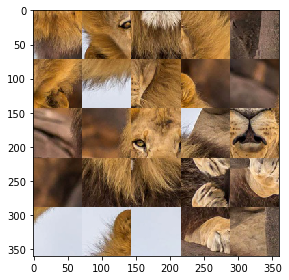

In [37]:
class GeneticAlgorithm:

  def __init__(self, image_path, n_rows):

    self.path = image_path
    self.n_rows = n_rows
    self.population_size = 100
    self.max_iteration = 300
    self.tournament_size = 10
    self.mutation_rate = 0.1
    self.selection_type = 'tournament'
    self.selection_size = 100
    self.elite_size = 10

  def get_diff(self, ind, piece, population):

    i = int(ind / 5)
    j = ind % 5

    # piece je size x size matrica piksela
    
    #print(f"i: {i}, j: {j}")

    if i == 4 and j == 4:
      return 0

    if i == 4:
      next = population[ind+1]
      next_left_edge = next[:][0]

      piece_right_edge = piece[:][-1]


      #print("Piece right edge:")
      #print(piece_right_edge)

      #print("Next left edge:")
      #print(next_left_edge)

      result = 0

      for i in range(len(next_left_edge)):
        result += next_left_edge[0] - piece_right_edge[0]
        result += next_left_edge[1] - piece_right_edge[1]
        result += next_left_edge[2] - piece_right_edge[2]

      return result

    if j == 4:
      next = population[ind+5]
      next_up_edge = next[0][:]

      piece_down_edge = piece[-1][:]

      result = 0

      for i in range(len(next_up_edge)):
        result += abs(next_up_edge[0] - piece_down_edge[0])
        result += abs(next_up_edge[1] - piece_down_edge[1])
        result += abs(next_up_edge[2] - piece_down_edge[2])

      return result

    next_left = population[ind+1]
    next_down = population[ind+5]

    next_left_left_edge = next_left[:][0]
    next_down_up_edge = next_down[0][:]

    piece_right_edge = piece[:][-1]
    piece_down_edge = piece[-1][:]

    result = 0
    for i in range(len(next_down_up_edge)):
      result += (next_left_left_edge[0] - piece_right_edge[0]) + (next_down_up_edge[0] - piece_down_edge[0])
      result += (next_left_left_edge[1] - piece_right_edge[1]) + (next_down_up_edge[1] - piece_down_edge[1])
      result += (next_left_left_edge[2] - piece_right_edge[2]) + (next_down_up_edge[2] - piece_down_edge[2])

    return result
 
  def calculate_fittness(self, genetic_code, index, population):

    fittness = 0
    # genetic_code je par gde je prva komponenta deo slike,
    # a druga je pozicija tog dela u originalnoj slici

    # population je niz parova genetic_code-a

    # genetic_code[0] je duzine 72
    # genetic_code[1] je int
    # genetic_code je duzine 2

    pieces = []
    for (piece, ind) in genetic_code:
      pieces.append(piece)

    i = 0      
    for piece in pieces:
      fittness += self.get_diff(i, piece, pieces)**2
      i += 1

    #print("===========================================================")

    return fittness
            
    
  def init_population(self):

    population = []
    rotations = []
    init_puzzle, step = from_image_to_pieces(self.path, self.n_rows, self.n_rows)

    for i in range(self.population_size):
      result, rot = shuffle(init_puzzle)
      population.append(result)
      rotations.append(rot)

    new_pop = []

    for i in range(len(population)):
      x = population[i]
      rot = rotations[i]
      image = x[0]
      ind = x[1]
      fittness = self.calculate_fittness(x, i, population)
      fittness = sum(fittness)
      new_pop.append(Chromosome(x, fittness, rot))

    return new_pop, step


  def selection(self, population, elite = False):

    # we will think about this later
    # population = sorted(population, key=lambda x: x[0].fittness)

    selection = []
    if elite == True:
      if self.elite_size > self.selection_size:
        selection = population[0:selection_size]
        return selection
      else:
        selection = population[0:elite_size]

    for i in range(self.selection_size - self.elite_size):
      tourn = random.sample(population, self.tournament_size)
      selection.append(max(tourn, key=lambda x: x.fittness))

    return selection

  def is_end(self, pieces):

    pieces = pieces.genetic_code

    for i in range(len(pieces)):
      if (pieces[i])[1] != (i):
        return False

    return True

  def cross(self, selection):
    return selection

  def mutation(self, selection):
    return selection

  def Optimize(self):

    population, step = self.init_population()

    global_best = Chromosome(None, math.inf, None)


    for i in range(self.max_iteration):
      selected = self.selection(population)
      population = self.cross(selected)
      population = self.mutation(selected)

      best = min(population, key=lambda x: x.fittness)

      if best.fittness < global_best.fittness:
        global_best = best

      if (self.is_end(best)):
        break

    return global_best, step

GA = GeneticAlgorithm("lion.jpg", 5)

best, step = GA.Optimize()

make_image(best.genetic_code, step, 5, 5)

